In [1]:
# import packages
!pip install dmba
import dmba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from dmba import plotDecisionTree, classificationSummary, liftChart, gainsChart

     |████████████████████████████████| 11.8 MB 23.3 MB/s 
no display found. Using non-interactive Agg backend


In [2]:
df = pd.read_csv('UniversalBankSample.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  4000 non-null   int64  
 1   Age                 4000 non-null   int64  
 2   Experience          4000 non-null   int64  
 3   Income              4000 non-null   int64  
 4   ZIP.Code            4000 non-null   int64  
 5   Family              4000 non-null   int64  
 6   CCAvg               4000 non-null   float64
 7   Education           4000 non-null   int64  
 8   Mortgage            4000 non-null   int64  
 9   Personal.Loan       4000 non-null   int64  
 10  Securities.Account  4000 non-null   int64  
 11  CD.Account          4000 non-null   int64  
 12  Online              4000 non-null   int64  
 13  CreditCard          4000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 437.6 KB


In [4]:
df = df.drop(columns = ['ID', 'ZIP.Code'])

In [5]:
predictors = ['Age','Experience','Income','Family','CCAvg','Education','Mortgage','Securities.Account','CD.Account','Online','CreditCard']
outcome = 'Personal.Loan'

In [6]:
X = pd.get_dummies(df[predictors])
y = df[outcome]

In [7]:
# partition the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [8]:
# Run a preliminary tree to determine important features
preTree = DecisionTreeClassifier(random_state = 1)

In [9]:
preTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [10]:
# Evaluate the tree
classificationSummary(y_valid, preTree.predict(X_valid))

Confusion Matrix (Accuracy 0.9769)

       Prediction
Actual    0    1
     0 1425   19
     1   18  138


In [11]:
# Find feature importances
importances = preTree.feature_importances_

In [12]:
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance':importances})
importance_df = importance_df.sort_values('importance')
print(importance_df)

               feature  importance
7   Securities.Account    0.000000
10          CreditCard    0.000000
6             Mortgage    0.008570
0                  Age    0.012948
8           CD.Account    0.013465
9               Online    0.014262
1           Experience    0.022660
4                CCAvg    0.050240
3               Family    0.129769
2               Income    0.355853
5            Education    0.392234


In [13]:
# Education, Income, Family, CCAvg, and Experience seem to be the most significant columns, so the others can be dropped.
predictors = ['Experience','Income','Family','CCAvg','Education']
outcome = 'Personal.Loan'

In [14]:
X = pd.get_dummies(df[predictors])
y = df[outcome]

In [15]:
# partition the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [17]:
# Run a second tree to determine evaluate the narrower dataset and find best parameters
secTree = DecisionTreeClassifier(random_state = 1)

In [18]:
secTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [19]:
# Evaluate the tree
classificationSummary(y_valid, secTree.predict(X_valid))

Confusion Matrix (Accuracy 0.9794)

       Prediction
Actual    0    1
     0 1428   16
     1   17  139


In [20]:
# Find best parameters
param_grid = {
    'max_depth': [5,10,15,20,25],
    'min_impurity_decrease':[0,0.001,0.005,0.01],
    'min_samples_split':[10,20,30,40,50],
}

In [21]:
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, n_jobs = 1)

In [22]:
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'max_depth': [5, 10, 15, 20, 25],
                         'min_impurity_decrease': [0, 0.001, 0.005, 0.01],
                         'min_samples_split': [10, 20, 30, 40, 50]})

In [23]:
print('Initial parameters ', gridSearch.best_params_)

Initial parameters  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 10}


In [24]:
param_grid = {
    'max_depth': [3,4,5,6,7,8,9,10,11,12],
    'min_impurity_decrease':[0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008],
    'min_samples_split':[4,6,8,10,12,14,16,18,20],
}

In [25]:
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, n_jobs = 1)

In [26]:
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_impurity_decrease': [0, 0.001, 0.002, 0.003,
                                                   0.004, 0.005, 0.006, 0.007,
                                                   0.008],
                         'min_samples_split': [4, 6, 8, 10, 12, 14, 16, 18,
                                               20]})

In [27]:
print('Improved parameters ', gridSearch.best_params_)

Improved parameters  {'max_depth': 8, 'min_impurity_decrease': 0, 'min_samples_split': 12}


In [28]:
# run a model with improved parameters
classTree = gridSearch.best_estimator_

In [31]:
classificationSummary(y_valid, classTree.predict(X_valid))

Confusion Matrix (Accuracy 0.9806)

       Prediction
Actual    0    1
     0 1433   11
     1   20  136


In [32]:
# run a boosted tree
boostedTree = AdaBoostClassifier(DecisionTreeClassifier(random_state = 1), n_estimators=100, random_state=1)

In [33]:
boostedTree.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                   n_estimators=100, random_state=1)

In [35]:
classes = classTree.classes_

In [36]:
classificationSummary(y_valid, boostedTree.predict(X_valid), class_names = classes)

Confusion Matrix (Accuracy 0.9794)

       Prediction
Actual    0    1
     0 1428   16
     1   17  139


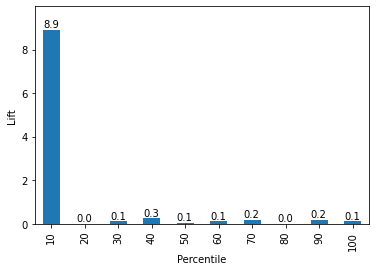

In [38]:
# Create the information for the lift chart
proba = boostedTree.predict_proba(X_valid)
result = pd.DataFrame({'actual': y_valid, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': boostedTree.predict(X_valid) })

df = result.sort_values(by=['p(1)'], ascending=False)
liftChart(df['actual'], title=False)
plt.show()
# the lift on the first decile is 8.9

In [39]:
# run a random forest
rforest = RandomForestClassifier(n_estimators=500, random_state=1)

In [40]:
rforest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [41]:
classificationSummary(y_valid, rforest.predict(X_valid), class_names = classes)

Confusion Matrix (Accuracy 0.9888)

       Prediction
Actual    0    1
     0 1444    0
     1   18  138


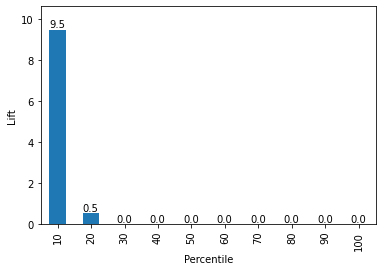

In [43]:
# Create the information for the lift chart
proba = rforest.predict_proba(X_valid)
result = pd.DataFrame({'actual': y_valid, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': rforest.predict(X_valid) })

df = result.sort_values(by=['p(1)'], ascending=False)
liftChart(df['actual'], title=False)
plt.show()
# the lift on the first decile is 9.5